<a href="https://colab.research.google.com/github/ucchol/Machine-Learning-CS--5361/blob/main/Copy_of_Colab_CNN_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2020 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Convolutional Neural Netowork - CIFAR 10

## Load Libraries

In this exercise, we will build and train a convolutional neural network using Keras.

Let's start by importing the libraries we will be using.

In [ ]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from keras.preprocessing.image import ImageDataGenerator


## Understanding the data
We'll train a convolutional neural network on the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. This consists of 60,000 color images (32x32x3). Each image is associated with 1 of 10 classes. The dataset was split by the creators; there are 50,000 training images and 10,000 test images. 

CIFAR-10 classes:
* airplane										
* automobile										
* bird										
* cat										
* deer										
* dog										
* frog										
* horse										
* ship										
* truck


### Load the data


In [ ]:
from keras.datasets import cifar10

# Load the Fashion MNIST dataset.
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

# Flatten Y_train and Y_test, so they become vectors of label values.
# The label for X_train[0] is in Y_train[0].
Y_train = Y_train.flatten()
Y_test = Y_test.flatten()

170508288/170498071 [==============================] - 2s 0us/step


### Basic Analysis
Let's print the shapes of `X_train`, `Y_train`, `X_test`, and `Y_test` to understand what we're dealing with.

In [ ]:
print("X_train.shape:", X_train.shape)
print("Y_train.shape:", Y_train.shape)
print("X_test.shape:", X_test.shape)
print("Y_test.shape:", Y_test.shape)


X_train.shape: (50000, 32, 32, 3)
Y_train.shape: (50000,)
X_test.shape: (10000, 32, 32, 3)
Y_test.shape: (10000,)


Before we continue, let's apply linear scaling to our pixel values, so they all fall between 0 and 1.

In [ ]:
# Pixel values range from 0 to 255. To normalize the data, 
# we just need to divide all values by 255
X_train = X_train / 255
X_test = X_test / 255

Next let's use the `imshow` function to look at the first few images in the training set.

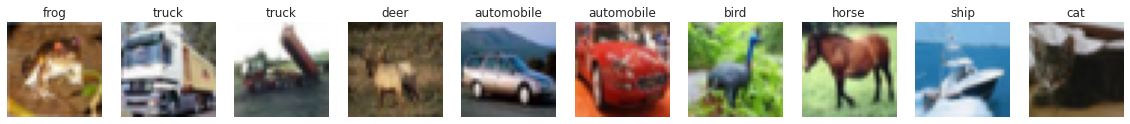

In [ ]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Create a figure with subplots. This returns a list of object handles in axs
# which we can use populate the plots.
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(20,10))
for i in range(10):
  image = X_train[i]
  label = Y_train[i]
  label_name = label_names[label]
  axs[i].imshow(image)
  axs[i].set_title(label_name)
  axs[i].axis('off')
plt.show()

### Data Shuffling
We'll be using SGD (Stochastic Gradient Descent) for training. This means that it is important that **each batch is a random sample of the data**.


In [ ]:
np.random.seed(0) # For reproducibility purposes

indices = np.arange(X_train.shape[0])
shuffled_indices = np.random.permutation(indices)

X_train = X_train[shuffled_indices]
Y_train = Y_train[shuffled_indices]

## Build a model
Now that we have our data ready, let's build our convolutional neural network! 



In [ ]:
def build_model(input_shape, learning_rate=0.01):
  """Build a TF logistic regression model using Keras.

  Args:
    input_shape: The shape of the model's input. 
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  num_classes = 10

  model = keras.Sequential()
  model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same',
                  input_shape=input_shape))
  model.add(keras.layers.Activation('relu'))
  
  model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3)))
  model.add(keras.layers.Activation('relu'))
  
  model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3)))
  model.add(keras.layers.Activation('relu'))
  model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

  model.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
  model.add(keras.layers.Activation('relu'))

  model.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3)))
  model.add(keras.layers.Activation('relu'))
  model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
  
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(units=512))
  model.add(keras.layers.Activation('relu'))

  model.add(keras.layers.Dense(units=num_classes))
  model.add(keras.layers.Activation('softmax'))
  # We need to choose an optimizer. We'll use SGD, which is actually mini-batch
  # SGD. We can specify the batch size to use for training later.
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  # Finally, we compile the model. This finalizes the graph for training.
  model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])


  return model


## Train a model
Let's train the model!

In [ ]:
model = build_model(input_shape=X_train[0].shape, learning_rate=0.01)

# Fit the model.
history = model.fit(
  x = X_train,   # our binary training examples
  y = Y_train,   # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size for SGD
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

# Convert the return value into a DataFrame so we can see the train loss 
# and binary accuracy after every epoch.
history = pd.DataFrame(history.history)
display(history)

Epoch 1/5
704/704 [==============================] - 17s 8ms/step - loss: 2.1804 - accuracy: 0.1958 - val_loss: 2.2489 - val_accuracy: 0.2060
Epoch 2/5
704/704 [==============================] - 5s 7ms/step - loss: 1.8470 - accuracy: 0.3388 - val_loss: 1.7676 - val_accuracy: 0.3730
Epoch 3/5
704/704 [==============================] - 5s 7ms/step - loss: 1.6168 - accuracy: 0.4225 - val_loss: 1.9483 - val_accuracy: 0.3604
Epoch 4/5
704/704 [==============================] - 5s 7ms/step - loss: 1.4672 - accuracy: 0.4780 - val_loss: 1.7850 - val_accuracy: 0.3732
Epoch 5/5
704/704 [==============================] - 5s 7ms/step - loss: 1.3702 - accuracy: 0.5104 - val_loss: 1.6306 - val_accuracy: 0.4522


,loss,accuracy,val_loss,val_accuracy
0,2.180403,0.195756,2.248894,0.2060
1,1.847014,0.338844,1.767604,0.3730
2,1.616849,0.422489,1.948330,0.3604
3,1.467204,0.477978,1.784956,0.3732
4,1.370153,0.510356,1.630644,0.4522


Your turn! Play around with the architecture of the network. Add/remove layers, use different hyperparameters, etc.

Be ready to share what you observe with the class.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 activation_2 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0

In [ ]:
def build_model(input_shape, learning_rate=0.01):
  """Build a TF logistic regression model using Keras.

  Args:
    input_shape: The shape of the model's input. 
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  num_classes = 10

  model = keras.Sequential()
  model.add(keras.layers.Conv2D(filters=256, kernel_size=(18, 18), padding='same',
                  input_shape=input_shape))
  model.add(keras.layers.Activation('relu'))
  
  model.add(keras.layers.Conv2D(filters=128, kernel_size=(18, 18)))
  model.add(keras.layers.Activation('relu'))
  
  model.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3)))
  model.add(keras.layers.Activation('relu'))
  model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

  model.add(keras.layers.Conv2D(filters=64, kernel_size=(9, 9), padding='same'))
  model.add(keras.layers.Activation('relu'))

  model.add(keras.layers.Conv2D(filters=64, kernel_size=(1, 1)))
  model.add(keras.layers.Activation('relu'))
  model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
  
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(units=512))
  model.add(keras.layers.Activation('relu'))

  model.add(keras.layers.Dense(units=num_classes))
  model.add(keras.layers.Activation('softmax'))
  # We need to choose an optimizer. We'll use SGD, which is actually mini-batch
  # SGD. We can specify the batch size to use for training later.
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  # Finally, we compile the model. This finalizes the graph for training.
  model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])


  return model

In [ ]:
model = build_model(input_shape=X_train[0].shape, learning_rate=0.01)

# Fit the model.
history = model.fit(
  x = X_train,   # our binary training examples
  y = Y_train,   # corresponding binary labels
  epochs=2,             # number of passes through the training data
  batch_size=64,        # mini-batch size for SGD
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

# Convert the return value into a DataFrame so we can see the train loss 
# and binary accuracy after every epoch.
history = pd.DataFrame(history.history)
display(history)

Epoch 1/2
704/704 [==============================] - 52s 70ms/step - loss: 2.0374 - accuracy: 0.2464 - val_loss: 2.0935 - val_accuracy: 0.2368
Epoch 2/2
704/704 [==============================] - 51s 72ms/step - loss: 1.7336 - accuracy: 0.3748 - val_loss: 1.8409 - val_accuracy: 0.3390


,loss,accuracy,val_loss,val_accuracy
0,2.037444,0.246378,2.093509,0.2368
1,1.733557,0.374844,1.840883,0.3390


In [ ]:
code = [1,2,3,4,5,6,7]
print(code)
movies = ["dune", "Incendies", "arrival", "sicario"]
print(movies)
print(len(movies))
print(movies[2])
movies.append("The Shining")
print(movies)
print(len(movies))
movies.insert(1, "Singing in the rain")
print(movies)
print(len(movies))
del(movies[2])
print(movies)
print(len(movies))

[1, 2, 3, 4, 5, 6, 7]
['dune', 'Incendies', 'arrival', 'sicario']
4
arrival
['dune', 'Incendies', 'arrival', 'sicario', 'The Shining']
5
['dune', 'Singing in the rain', 'Incendies', 'arrival', 'sicario', 'The Shining']
6
['dune', 'Singing in the rain', 'arrival', 'sicario', 'The Shining']
5
